# USA Regional Sales Analysis  

## Data overview and initial validation  

This notebook explores a five year snapshot of United States sales for a fictional consumer goods company.  
Each row in the main table represents a single order line for a specific product, quantity, price, and customer.  

The source Excel workbook contains several related tables  

* Sales Orders  
* Customers  
* Products  
* Regions  
* State Regions  
* 2017 Budgets  

The Sales Orders sheet is the transactional table, at the level of individual order lines.  
The other sheets act as lookup tables that provide names, geography and budget targets.  

In this notebook we will  

* import the raw tables from Excel  
* perform basic structure checks  
* clean and merge the tables into one analysis dataset  
* create exploratory charts for revenue, profit and regional patterns  


## Setup and configuration

In [19]:
# Import core libraries for data handling and charts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure notebook display for charts
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## Data ingestion  

In [20]:
# Path to the original Excel dataset
file_path = "../data_raw/regional_sales_dataset_raw.xlsx"

# Load the workbook and inspect sheet names
xls = pd.ExcelFile(file_path)

# Display all sheet names to confirm structure
xls.sheet_names


['Sales Orders',
 'Customers',
 'Regions',
 'State Regions',
 'Products',
 '2017 Budgets']

### Load source tables  

The Excel workbook contains six sheets  

Sales Orders  
Customers  
Regions  
State Regions  
Products  
2017 Budgets  

In this step we read all sheets into pandas dataframes so we can inspect and clean them later  


In [21]:
# Read all sheets from the Excel workbook into a dictionary
sheets = pd.read_excel(file_path, sheet_name=None)

# Show the keys to confirm that all expected sheets were loaded
sheets.keys()


dict_keys(['Sales Orders', 'Customers', 'Regions', 'State Regions', 'Products', '2017 Budgets'])

### Assign tables to dataframes  

In [22]:
# Extract each sheet into its own dataframe
# This keeps the structure clear and easy to work with

df_sales = sheets["Sales Orders"]
df_customers = sheets["Customers"]
df_regions = sheets["Regions"]
df_state_regions = sheets["State Regions"]
df_products = sheets["Products"]
df_budgets = sheets["2017 Budgets"]

# Preview the Sales Orders and Customers tables
df_sales.head(), df_customers.head()


(    OrderNumber  OrderDate  Customer Name Index      Channel Currency Code  \
 0   SO - 000225 2014-01-01                  126    Wholesale           USD   
 1  SO - 0003378 2014-01-01                   96  Distributor           USD   
 2  SO - 0005126 2014-01-01                    8    Wholesale           USD   
 3  SO - 0005614 2014-01-01                   42       Export           USD   
 4  SO - 0005781 2014-01-01                   73    Wholesale           USD   
 
   Warehouse Code  Delivery Region Index  Product Description Index  \
 0         AXW291                    364                         27   
 1         AXW291                    488                         20   
 2         AXW291                    155                         26   
 3         AXW291                    473                          7   
 4         AXW291                    256                          8   
 
    Order Quantity  Unit Price  Line Total  Total Unit Cost  
 0               6      2499.1    

## Data overview and quick validation

Here we do a light check of all source tables

- Confirm shapes  
- Inspect column structure for the State Regions table  
- Make sure basic types look reasonable before any cleaning

In [23]:
# Quick shape overview for all raw tables

tables = {
    "sales_orders": df_sales,
    "customers": df_customers,
    "regions": df_regions,
    "state_regions": df_state_regions,
    "products": df_products,
    "budgets_2017": df_budgets,
}

for name, df in tables.items():
    print(f"Table name: {name}")
    print(f"Shape (rows, columns): {df.shape}")
    print()  # blank line for readability


Table name: sales_orders
Shape (rows, columns): (64104, 12)

Table name: customers
Shape (rows, columns): (175, 2)

Table name: regions
Shape (rows, columns): (994, 15)

Table name: state_regions
Shape (rows, columns): (49, 3)

Table name: products
Shape (rows, columns): (30, 2)

Table name: budgets_2017
Shape (rows, columns): (30, 2)



### Inspect State Regions header structure

In [24]:
# Inspect the raw structure of the State Regions sheet
# This helps confirm whether headers are in the first row or stored as data

print("Current columns:", list(df_state_regions.columns))
print()
df_state_regions.head()


Current columns: ['Column1', 'Column2', 'Column3']



,Column1,Column2,Column3
0,State Code,State,Region
1,AL,Alabama,South
2,AR,Arkansas,South
3,AZ,Arizona,West
4,CA,California,West


### Fix State Regions header  

The State Regions sheet contains the real headers in row 0.  
We convert row 0 into header names and drop it from the data.

In [25]:
# Convert row 0 into proper column names
df_state_regions.columns = df_state_regions.iloc[0]

# Drop the old header row and reset index
df_state_regions = df_state_regions[1:].reset_index(drop=True)

# Preview the cleaned table
df_state_regions.head()


,State Code,State,Region
0,AL,Alabama,South
1,AR,Arkansas,South
2,AZ,Arizona,West
3,CA,California,West
4,CO,Colorado,West


## Data cleaning and standardization  

Before merging tables together, we clean column names so that  

• all names use lowercase  
• spaces are replaced with underscores  
• tables share a consistent naming style  

In [26]:
# Standardize column names across all tables
# This ensures consistency and avoids merge errors later

def clean_columns(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
    )
    return df

df_sales = clean_columns(df_sales)
df_customers = clean_columns(df_customers)
df_regions = clean_columns(df_regions)
df_state_regions = clean_columns(df_state_regions)
df_products = clean_columns(df_products)
df_budgets = clean_columns(df_budgets)

# Check the cleaned column names of the sales table
df_sales.head()

,ordernumber,orderdate,customer_name_index,channel,currency_code,warehouse_code,delivery_region_index,product_description_index,order_quantity,unit_price,line_total,total_unit_cost
0,SO - 000225,2014-01-01,126,Wholesale,USD,AXW291,364,27,6,2499.1,14994.6,1824.343
1,SO - 0003378,2014-01-01,96,Distributor,USD,AXW291,488,20,11,2351.7,25868.7,1269.918
2,SO - 0005126,2014-01-01,8,Wholesale,USD,AXW291,155,26,6,978.2,5869.2,684.740
3,SO - 0005614,2014-01-01,42,Export,USD,AXW291,473,7,7,2338.3,16368.1,1028.852
4,SO - 0005781,2014-01-01,73,Wholesale,USD,AXW291,256,8,8,2291.4,18331.2,1260.270


### Pre merge validation  

Before joining tables, we verify that the primary transactional table has  

• no unexpected duplicates  
• reasonable column data types  
• no abnormal missing values  

In [27]:
# Check for duplicate rows in the sales table
duplicates = df_sales.duplicated().sum()
print("Number of duplicate rows in df_sales:", duplicates)

# Check for missing values in the sales table
print("\nMissing values per column:")
print(df_sales.isnull().sum())

# Show data types
print("\nData types:")
df_sales.dtypes

Number of duplicate rows in df_sales: 0

Missing values per column:
ordernumber                  0
orderdate                    0
customer_name_index          0
channel                      0
currency_code                0
warehouse_code               0
delivery_region_index        0
product_description_index    0
order_quantity               0
unit_price                   0
line_total                   0
total_unit_cost              0
dtype: int64

Data types:


ordernumber                          object
orderdate                    datetime64[ns]
customer_name_index                   int64
channel                              object
currency_code                        object
warehouse_code                       object
delivery_region_index                 int64
product_description_index             int64
order_quantity                        int64
unit_price                          float64
line_total                          float64
total_unit_cost                     float64
dtype: object

## Data merging  

In this section we combine all lookup tables with the main Sales Orders table.  
Each merge brings in descriptive information  

• customer names  
• product names  
• city and state details  
• broad US region  
• product budgets for 2017  

The result will be one unified analysis dataset.

In [28]:
# Merge Sales with Customers
df = df_sales.merge(
    df_customers,
    how="left",
    left_on="customer_name_index",
    right_on="customer_index"
)

# Merge with Products
df = df.merge(
    df_products,
    how="left",
    left_on="product_description_index",
    right_on="index"
)

# Merge with Regions
df = df.merge(
    df_regions,
    how="left",
    left_on="delivery_region_index",
    right_on="id"
)

# Merge with State Regions
df = df.merge(
    df_state_regions,
    how="left",
    left_on="state_code",
    right_on="state_code"
)

# Merge with Budgets
df = df.merge(
    df_budgets,
    how="left",
    on="product_name"
)

# Preview the merged dataset
df.head()


,ordernumber,orderdate,customer_name_index,channel,currency_code,warehouse_code,delivery_region_index,product_description_index,order_quantity,unit_price,...,area_code,population,households,median_income,land_area,water_area,time_zone,state_y,region,2017_budgets
0,SO - 000225,2014-01-01,126,Wholesale,USD,AXW291,364,27,6,2499.1,...,912,145674,52798,36466,268318796,13908113,America/New York,Georgia,South,964940.231
1,SO - 0003378,2014-01-01,96,Distributor,USD,AXW291,488,20,11,2351.7,...,317,55586,20975,54176,72276415,1883,America/Indiana/Indianapolis,Indiana,Midwest,2067108.120
2,SO - 0005126,2014-01-01,8,Wholesale,USD,AXW291,155,26,6,978.2,...,925,79510,26020,124759,62489257,386195,America/Los Angeles,California,West,5685138.270
3,SO - 0005614,2014-01-01,42,Export,USD,AXW291,473,7,7,2338.3,...,812,84067,30232,30019,60221613,475857,America/Indiana/Indianapolis,Indiana,Midwest,889737.555
4,SO - 0005781,2014-01-01,73,Wholesale,USD,AXW291,256,8,8,2291.4,...,959,58007,24141,63158,70972793,720300,America/New York,Connecticut,Northeast,1085037.329


### Column selection and renaming  

We remove intermediate lookup fields and keep only the columns required for final analysis.  
Then we rename them into clean, descriptive snake_case names.

In [31]:
# Select the key columns needed for analysis
cols_to_keep = [
    "ordernumber",
    "orderdate",
    "customer_names",
    "channel",
    "product_name",
    "order_quantity",
    "unit_price",
    "line_total",
    "total_unit_cost",
    "state_code",
    "state_y",       
    "region",
    "latitude",
    "longitude",
    "2017_budgets"
]

df = df[cols_to_keep]

# Rename columns to clean analysis-ready names
df = df.rename(columns={
    "ordernumber": "order_number",
    "orderdate": "order_date",
    "customer_names": "customer_name",
    "order_quantity": "quantity",
    "unit_price": "unit_price",
    "line_total": "revenue",
    "total_unit_cost": "cost",
    "state_code": "state",
    "state_y": "state_name",
    "region": "us_region",
    "latitude": "lat",
    "longitude": "lon",
    "2017_budgets": "budget"
})

# Preview the cleaned dataset
df.head()


,order_number,order_date,customer_name,channel,product_name,quantity,unit_price,revenue,cost,state,state_name,us_region,lat,lon,budget
0,SO - 000225,2014-01-01,Rhynoodle Ltd,Wholesale,Product 27,6,2499.1,14994.6,1824.343,GA,Georgia,South,32.08354,-81.09983,964940.231
1,SO - 0003378,2014-01-01,Thoughtmix Ltd,Distributor,Product 20,11,2351.7,25868.7,1269.918,IN,Indiana,Midwest,39.61366,-86.10665,2067108.120
2,SO - 0005126,2014-01-01,Amerisourc Corp,Wholesale,Product 26,6,978.2,5869.2,684.740,CA,California,West,37.66243,-121.87468,5685138.270
3,SO - 0005614,2014-01-01,Colgate-Pa Group,Export,Product 7,7,2338.3,16368.1,1028.852,IN,Indiana,Midwest,39.16533,-86.52639,889737.555
4,SO - 0005781,2014-01-01,Deseret Group,Wholesale,Product 8,8,2291.4,18331.2,1260.270,CT,Connecticut,Northeast,41.77524,-72.52443,1085037.329


### Budget cleanup  

Budget values apply only to the year 2017.  
We remove budget values for all other years in the dataset.


In [32]:
# Remove budget values for non-2017 rows
df.loc[df["order_date"].dt.year != 2017, "budget"] = pd.NA

# Verify the cleanup
df[["order_date", "product_name", "revenue", "budget"]].head(10)


,order_date,product_name,revenue,budget
0,2014-01-01,Product 27,14994.6,NaN
1,2014-01-01,Product 20,25868.7,NaN
2,2014-01-01,Product 26,5869.2,NaN
3,2014-01-01,Product 7,16368.1,NaN
4,2014-01-01,Product 8,18331.2,NaN
5,2014-01-01,Product 23,57412.3,NaN
6,2014-01-01,Product 1,20120.1,NaN
7,2014-01-01,Product 25,10452.0,NaN
8,2014-01-01,Product 13,19262.5,NaN
9,2014-01-01,Product 14,34974.0,NaN


### Feature engineering  

We create additional fields used later in the analysis

• total_cost  
• profit  
• profit_margin_pct  
• order_month_name  
• order_month_num  
• order_month (period)  

In [33]:
# Total cost for the line item
df["total_cost"] = df["quantity"] * df["cost"]

# Profit
df["profit"] = df["revenue"] - df["total_cost"]

# Profit margin percentage
df["profit_margin_pct"] = (df["profit"] / df["revenue"]) * 100

# Month name
df["order_month_name"] = df["order_date"].dt.month_name()

# Month number (for sorting)
df["order_month_num"] = df["order_date"].dt.month

# Monthly period (YYYY-MM)
df["order_month"] = df["order_date"].dt.to_period("M")

# Quick preview
df.head()


,order_number,order_date,customer_name,channel,product_name,quantity,unit_price,revenue,cost,state,...,us_region,lat,lon,budget,total_cost,profit,profit_margin_pct,order_month_name,order_month_num,order_month
0,SO - 000225,2014-01-01,Rhynoodle Ltd,Wholesale,Product 27,6,2499.1,14994.6,1824.343,GA,...,South,32.08354,-81.09983,NaN,10946.058,4048.542,27.0,January,1,2014-01
1,SO - 0003378,2014-01-01,Thoughtmix Ltd,Distributor,Product 20,11,2351.7,25868.7,1269.918,IN,...,Midwest,39.61366,-86.10665,NaN,13969.098,11899.602,46.0,January,1,2014-01
2,SO - 0005126,2014-01-01,Amerisourc Corp,Wholesale,Product 26,6,978.2,5869.2,684.740,CA,...,West,37.66243,-121.87468,NaN,4108.440,1760.760,30.0,January,1,2014-01
3,SO - 0005614,2014-01-01,Colgate-Pa Group,Export,Product 7,7,2338.3,16368.1,1028.852,IN,...,Midwest,39.16533,-86.52639,NaN,7201.964,9166.136,56.0,January,1,2014-01
4,SO - 0005781,2014-01-01,Deseret Group,Wholesale,Product 8,8,2291.4,18331.2,1260.270,CT,...,Northeast,41.77524,-72.52443,NaN,10082.160,8249.040,45.0,January,1,2014-01


### Data quality validation  

Before running EDA charts we confirm  

• schema structure  
• numeric ranges  
• missing values  
• date ranges  
• overall sanity checks  

In [34]:
# Overview of the full cleaned dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64104 entries, 0 to 64103
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_number       64104 non-null  object        
 1   order_date         64104 non-null  datetime64[ns]
 2   customer_name      64104 non-null  object        
 3   channel            64104 non-null  object        
 4   product_name       64104 non-null  object        
 5   quantity           64104 non-null  int64         
 6   unit_price         64104 non-null  float64       
 7   revenue            64104 non-null  float64       
 8   cost               64104 non-null  float64       
 9   state              64104 non-null  object        
 10  state_name         64104 non-null  object        
 11  us_region          64104 non-null  object        
 12  lat                64104 non-null  float64       
 13  lon                64104 non-null  float64       
 14  budget

In [35]:
# Summary statistics for key numeric fields
df[["quantity", "unit_price", "revenue", "cost", "profit", "profit_margin_pct"]].describe()


,quantity,unit_price,revenue,cost,profit,profit_margin_pct
count,64104.000000,64104.000000,64104.000000,64104.000000,64104.000000,64104.000000
mean,8.441689,2284.380803,19280.682937,1432.083899,7203.490577,37.359416
std,2.276217,1663.598141,15429.602766,1107.705728,6626.122492,13.238648
min,5.000000,167.500000,837.500000,68.675000,125.625000,15.000000
25%,6.000000,1031.800000,8019.900000,606.216000,2542.549500,26.000000
50%,8.000000,1855.900000,14023.100000,1084.495500,5091.464000,37.000000
75%,10.000000,3606.275000,27416.400000,2046.933750,9922.164000,49.000000
max,12.000000,6566.000000,78711.600000,5498.556000,45559.464000,60.000000


In [36]:
# Check missing values again after feature engineering
df.isnull().sum()

order_number             0
order_date               0
customer_name            0
channel                  0
product_name             0
quantity                 0
unit_price               0
revenue                  0
cost                     0
state                    0
state_name               0
us_region                0
lat                      0
lon                      0
budget               48841
total_cost               0
profit                   0
profit_margin_pct        0
order_month_name         0
order_month_num          0
order_month              0
dtype: int64

### Export cleaned dataset  

The cleaned analysis ready dataset will be saved to the  
`data_processed` folder for use in future notebooks and tools.  

In [37]:
# Export the final cleaned dataframe to CSV
output_path = "../data_processed/usa_regional_sales_clean.csv"

df.to_csv(output_path, index=False)

print(f"Cleaned dataset saved to {output_path}")


Cleaned dataset saved to ../data_processed/usa_regional_sales_clean.csv


## Exploratory Data Analysis  
This section covers all charts and summaries built from the cleaned dataset.  
We start by configuring visualization settings for consistent styling.

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configure notebook wide visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12


## Monthly Revenue Trend  
Shows how total revenue changes month by month across the full timeline.  
Helps identify seasonal patterns, downturns, or unusual spikes.

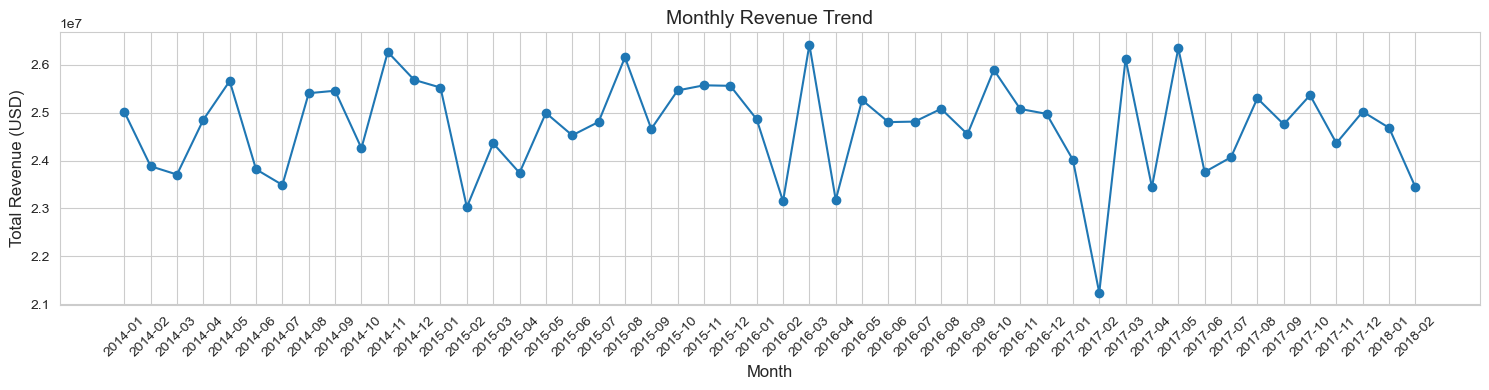

In [39]:
# Convert order_date to a monthly period
df["order_month"] = df["order_date"].dt.to_period("M")

# Aggregate total revenue per month
monthly_sales = df.groupby("order_month")["revenue"].sum()

# Plot trend
plt.figure(figsize=(15, 4))
plt.plot(monthly_sales.index.astype(str), monthly_sales.values, marker="o")

plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Total Revenue (USD)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Seasonality Pattern Across All Years  
This view aggregates revenue by calendar month to reveal recurring seasonal behavior.  
Shows whether certain months consistently perform better or worse each year.

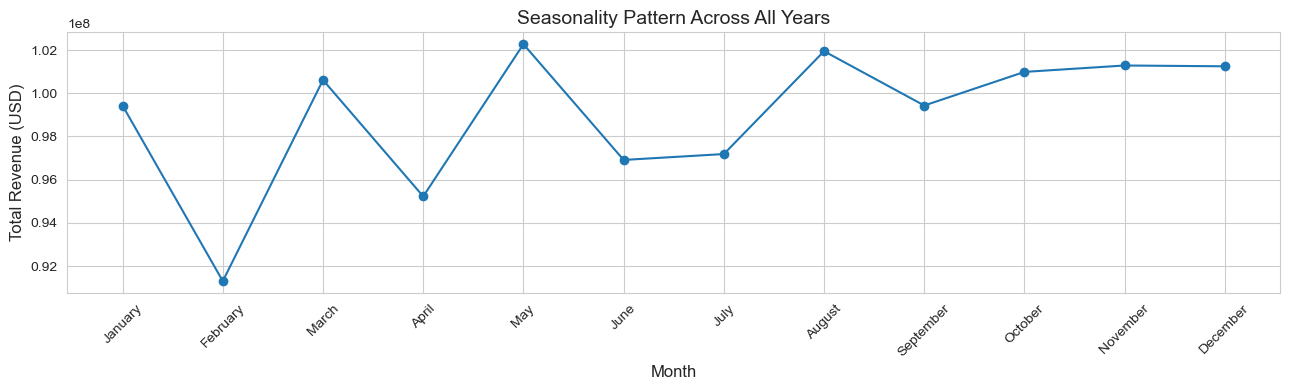

In [40]:
# Exclude early 2018 partial data
df_season = df[df["order_date"].dt.year != 2018]

# Group by calendar month
seasonal = (
    df_season
    .groupby(["order_month_num", "order_month_name"])["revenue"]
    .sum()
    .sort_index()
)

# Plot
plt.figure(figsize=(13, 4))
plt.plot(
    seasonal.index.get_level_values(1),
    seasonal.values,
    marker="o"
)

plt.title("Seasonality Pattern Across All Years")
plt.xlabel("Month")
plt.ylabel("Total Revenue (USD)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Top ten products by revenue  
This identifies which products generate the highest total revenue across the full dataset.  
Useful for understanding the product mix and spotting the strongest performers.

C:\Users\adnan\AppData\Local\Temp\ipykernel_30516\1667466158.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


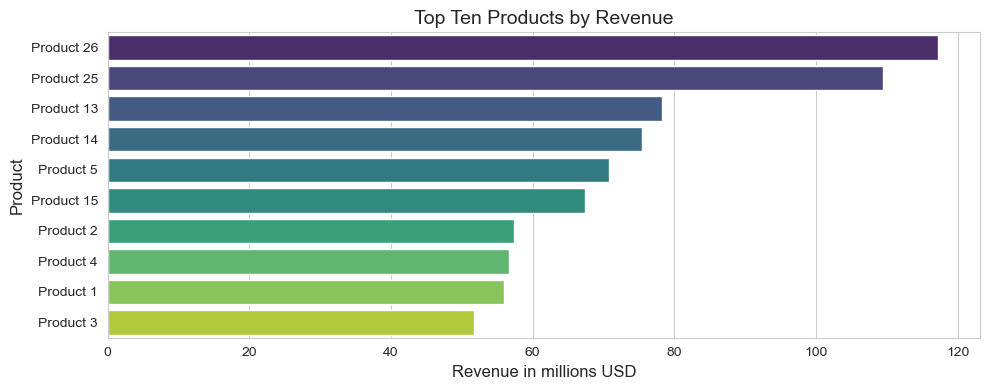

In [41]:
# Compute total revenue by product
prod_revenue = df.groupby("product_name")["revenue"].sum()

# Select top ten
top10 = prod_revenue.sort_values(ascending=False).head(10)

# Convert revenue to millions for readability
top10_m = top10 / 1e6

# Plot
plt.figure(figsize=(10, 4))
sns.barplot(
    x=top10_m.values,
    y=top10_m.index,
    palette="viridis"
)

plt.title("Top Ten Products by Revenue")
plt.xlabel("Revenue in millions USD")
plt.ylabel("Product")

plt.tight_layout()
plt.show()


## Top ten products by average profit  
This shows which products deliver the highest average profit per order line.  
It helps identify items that contribute the most to bottom line profitability.


C:\Users\adnan\AppData\Local\Temp\ipykernel_30516\3112555601.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


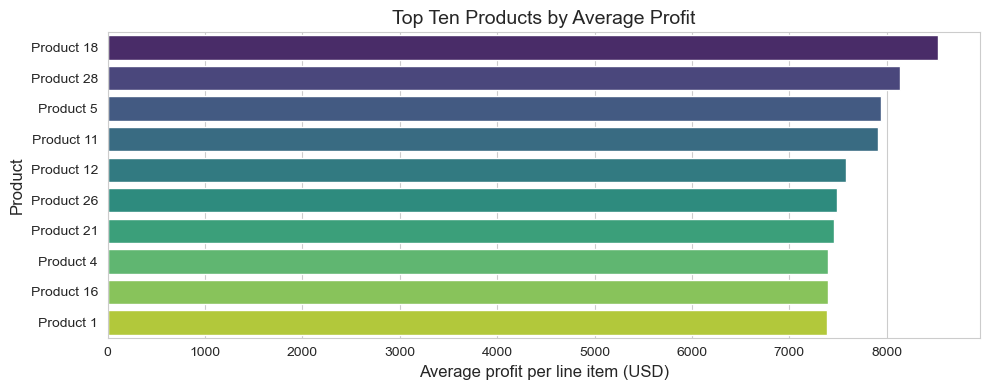

In [42]:
# Compute average profit per product
top_profit = (
    df.groupby("product_name")["profit"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
)

# Plot
plt.figure(figsize=(10, 4))
sns.barplot(
    x=top_profit.values,
    y=top_profit.index,
    palette="viridis"
)

plt.title("Top Ten Products by Average Profit")
plt.xlabel("Average profit per line item (USD)")
plt.ylabel("Product")

plt.tight_layout()
plt.show()


## Sales by channel  
This view shows how total revenue is distributed across sales channels.
It helps identify which channel contributes the most to overall revenue.

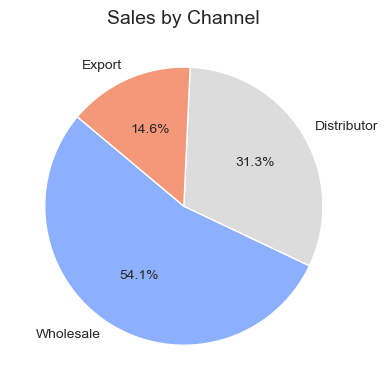

In [43]:
# Total revenue by sales channel
channel_sales = (
    df.groupby("channel")["revenue"]
      .sum()
      .sort_values(ascending=False)
)

plt.figure(figsize=(6, 4))
plt.pie(
    channel_sales.values,
    labels=channel_sales.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("coolwarm", len(channel_sales))
)

plt.title("Sales by Channel")
plt.tight_layout()
plt.show()


## Average order value distribution  
This shows how much customers typically spend per order.  
It helps reveal common spending ranges and whether there are unusually large orders.


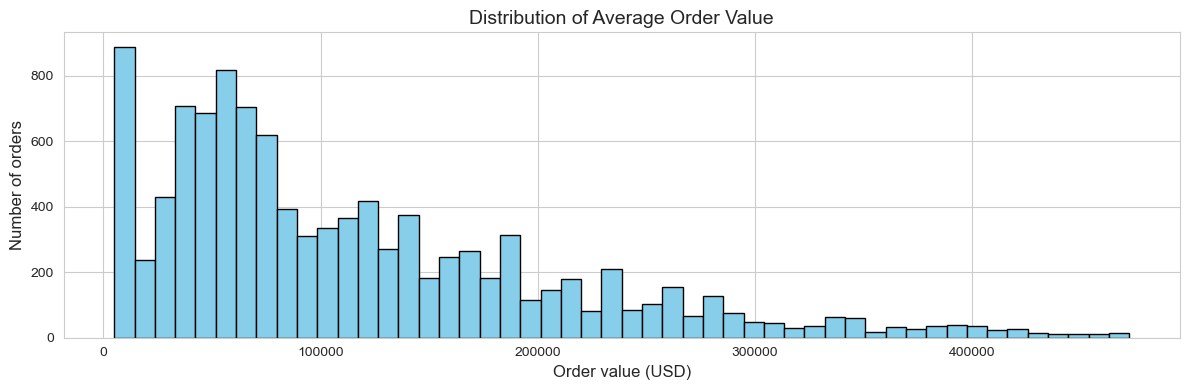

In [44]:
# Total revenue per unique order
aov = df.groupby("order_number")["revenue"].sum()

plt.figure(figsize=(12, 4))
plt.hist(
    aov,
    bins=50,
    color="skyblue",
    edgecolor="black"
)

plt.title("Distribution of Average Order Value")
plt.xlabel("Order value (USD)")
plt.ylabel("Number of orders")

plt.tight_layout()
plt.show()


## Profit margin percentage versus unit price  

This view checks whether higher priced items tend to have better or worse profit margins.  
Each point is a single order line with its unit price on the x axis and profit margin percentage on the y axis.


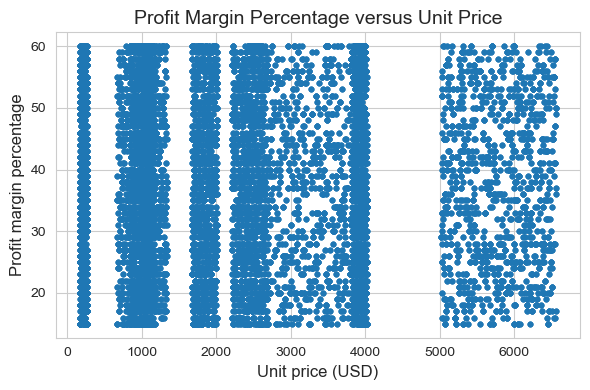

In [45]:
# Scatter plot of unit price versus profit margin percentage

plt.figure(figsize=(6, 4))

# Each point is one order line
plt.scatter(
    df["unit_price"],
    df["profit_margin_pct"],
    alpha=0.6,          # a bit transparent so dense areas are visible
    s=10                # small points since there are many records
)

plt.title("Profit Margin Percentage versus Unit Price")
plt.xlabel("Unit price (USD)")
plt.ylabel("Profit margin percentage")

plt.tight_layout()
plt.show()


## Unit price distribution per product  

This view compares pricing spread and outliers across all products.  
A boxplot helps reveal median price, quartiles, and extreme values for each product category.


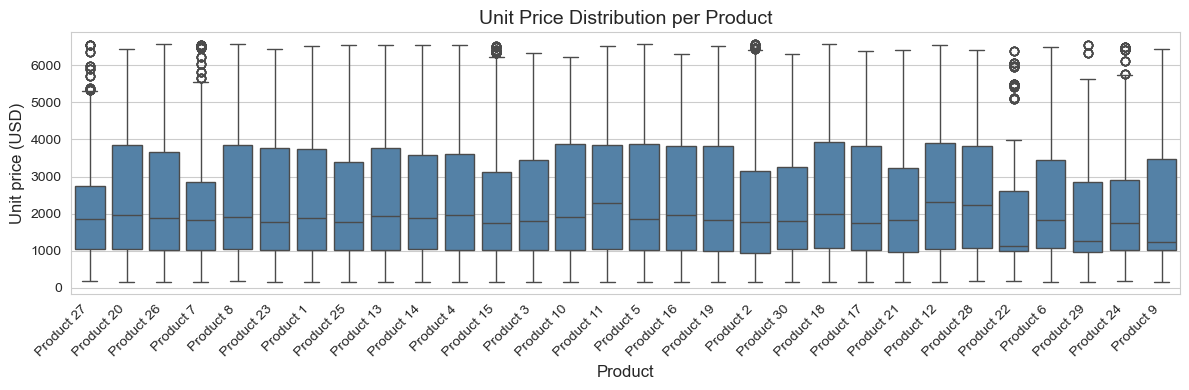

In [46]:
plt.figure(figsize=(12, 4))

sns.boxplot(
    data=df,
    x="product_name",
    y="unit_price",
    color="steelblue"
)

plt.title("Unit Price Distribution per Product")
plt.xlabel("Product")
plt.ylabel("Unit price (USD)")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


## Total sales by US region  

This chart compares revenue across broad US regions.  
It helps highlight which regions contribute the most to overall sales volume.

C:\Users\adnan\AppData\Local\Temp\ipykernel_30516\1567602989.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


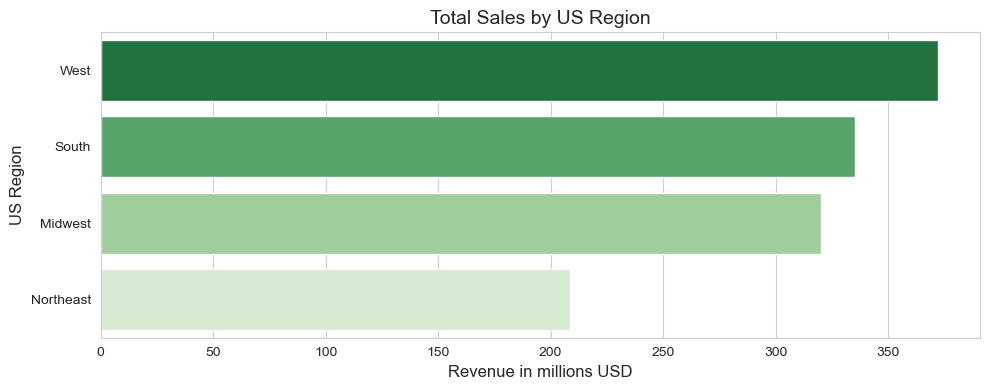

In [47]:
region_sales = (
    df.groupby("us_region")["revenue"]
      .sum()
      .sort_values(ascending=False) / 1e6
)

plt.figure(figsize=(10, 4))

sns.barplot(
    x=region_sales.values,
    y=region_sales.index,
    palette="Greens_r"
)

plt.title("Total Sales by US Region")
plt.xlabel("Revenue in millions USD")
plt.ylabel("US Region")

plt.tight_layout()
plt.show()


## Total sales by state  

This chart lists the top ten states by total revenue.  
It surfaces which states drive the most demand and where growth opportunities may exist.


C:\Users\adnan\AppData\Local\Temp\ipykernel_30516\3807376097.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


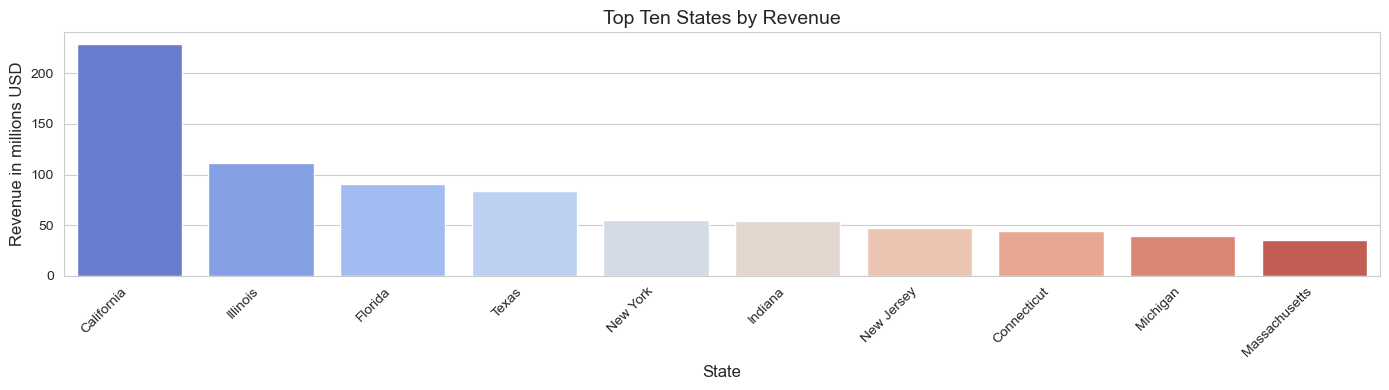

In [48]:
state_sales = (
    df.groupby("state_name")["revenue"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(14, 4))

sns.barplot(
    x=state_sales.index,
    y=state_sales.values / 1e6,
    palette="coolwarm"
)

plt.title("Top Ten States by Revenue")
plt.xlabel("State")
plt.ylabel("Revenue in millions USD")

plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


## Top ten states by number of orders  

This chart ranks states based on order volume rather than total revenue.  
It highlights where the highest number of transactions occur, which may differ from revenue concentration.


C:\Users\adnan\AppData\Local\Temp\ipykernel_30516\4249883931.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


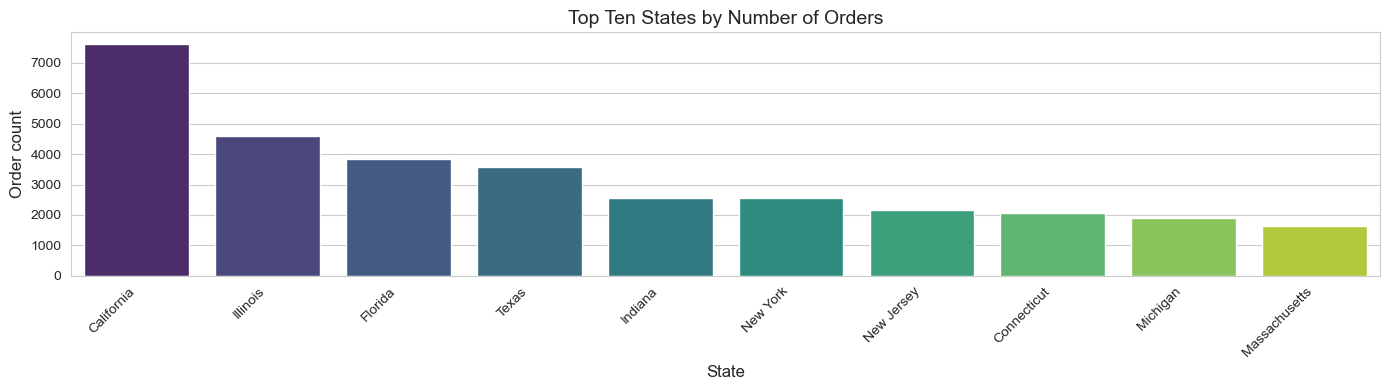

In [49]:
state_orders = (
    df.groupby("state_name")["order_number"]
      .nunique()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(14, 4))

sns.barplot(
    x=state_orders.index,
    y=state_orders.values,
    palette="viridis"
)

plt.title("Top Ten States by Number of Orders")
plt.xlabel("State")
plt.ylabel("Order count")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Customer revenue distribution  

This section highlights the highest and lowest revenue-generating customers.  
It shows where revenue is concentrated and where smaller accounts sit in the portfolio.


C:\Users\adnan\AppData\Local\Temp\ipykernel_30516\3979238985.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\adnan\AppData\Local\Temp\ipykernel_30516\3979238985.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


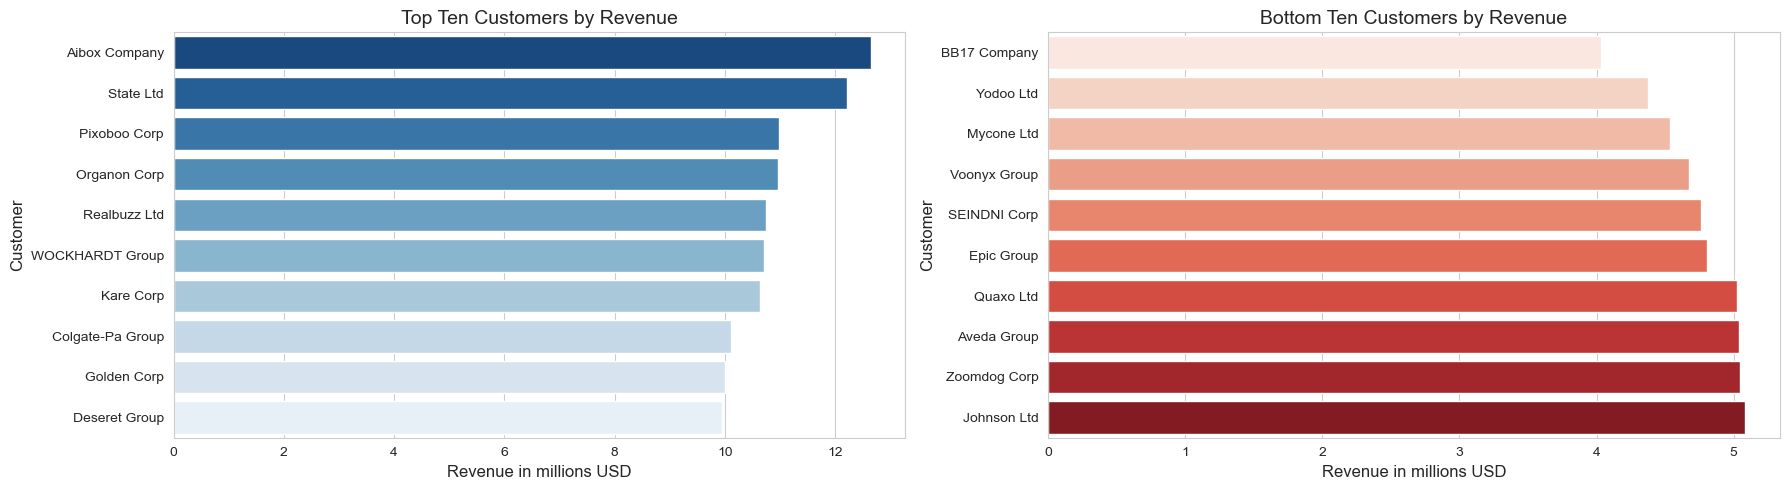

In [50]:
top_rev = (
    df.groupby("customer_name")["revenue"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

bottom_rev = (
    df.groupby("customer_name")["revenue"]
      .sum()
      .sort_values(ascending=True)
      .head(10)
)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(
    x=top_rev.values / 1e6,
    y=top_rev.index,
    palette="Blues_r",
    ax=axes[0]
)
axes[0].set_title("Top Ten Customers by Revenue")
axes[0].set_xlabel("Revenue in millions USD")
axes[0].set_ylabel("Customer")

sns.barplot(
    x=bottom_rev.values / 1e6,
    y=bottom_rev.index,
    palette="Reds",
    ax=axes[1]
)
axes[1].set_title("Bottom Ten Customers by Revenue")
axes[1].set_xlabel("Revenue in millions USD")
axes[1].set_ylabel("Customer")

plt.tight_layout()
plt.show()


## Channel profitability comparison  

This view compares the average profit margin across the three sales channels.  
It highlights which channel delivers stronger margins and whether profitability is consistent.


C:\Users\adnan\AppData\Local\Temp\ipykernel_30516\2270599071.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


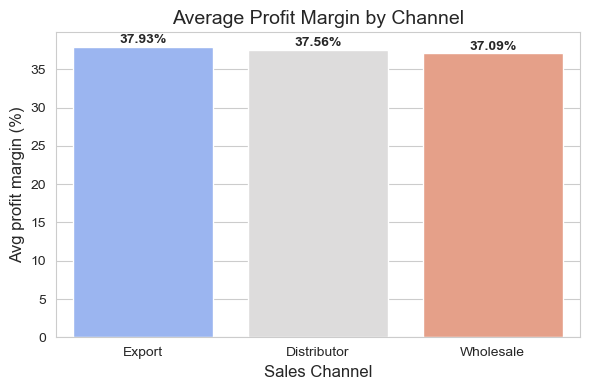

In [51]:
channel_margin = (
    df.groupby("channel")["profit_margin_pct"]
      .mean()
      .sort_values(ascending=False)
)

plt.figure(figsize=(6, 4))
ax = sns.barplot(
    x=channel_margin.index,
    y=channel_margin.values,
    palette="coolwarm"
)

plt.title("Average Profit Margin by Channel")
plt.xlabel("Sales Channel")
plt.ylabel("Avg profit margin (%)")

for i, v in enumerate(channel_margin.values):
    ax.text(i, v + 0.5, f"{v:.2f}%", ha="center", fontweight="bold")

plt.tight_layout()
plt.show()


## Customer segmentation  
This bubble chart segments customers based on total revenue, average margin, and number of orders.  
It helps identify high value clients, low margin clients, and potential growth targets.


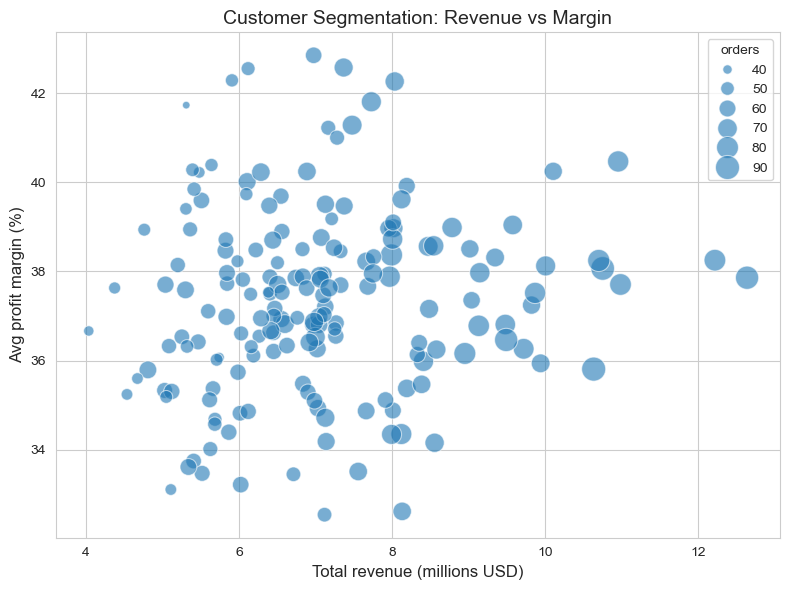

In [52]:
cust_summary = df.groupby("customer_name").agg(
    total_revenue=("revenue", "sum"),
    avg_margin=("profit_margin_pct", "mean"),
    orders=("order_number", "nunique")
)

cust_summary["total_revenue_m"] = cust_summary["total_revenue"] / 1e6

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=cust_summary,
    x="total_revenue_m",
    y="avg_margin",
    size="orders",
    sizes=(30, 300),
    alpha=0.6
)

plt.title("Customer Segmentation: Revenue vs Margin")
plt.xlabel("Total revenue (millions USD)")
plt.ylabel("Avg profit margin (%)")

plt.tight_layout()
plt.show()


## Correlation matrix  
This heatmap shows relationships between key numeric variables such as quantity, price, revenue, cost, and profit.  
It helps identify where strong linear relationships exist.


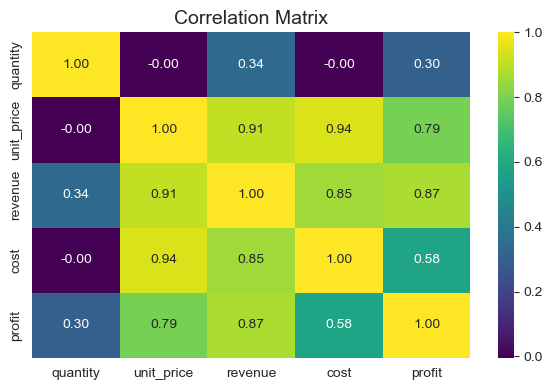

In [53]:
num_cols = ["quantity", "unit_price", "revenue", "cost", "profit"]

corr = df[num_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="viridis"
)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()
